In [1]:
import sys
sys.path.append('..')

from utils.common import read_beacon_coords, read_beacon_data, process_beacon_data_for_strongthree, process_beacon_data_for_pos
import argparse
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
# visualize the beacon RSSI to distance
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
from scipy.signal import medfilt
from filterpy.kalman import KalmanFilter

[[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -59, 'accuracy': 7.721894863531677, 'time': 1724997649446}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724997649446}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -59, 'accuracy': 7.721894863531677, 'time': 1724997649542}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724997649542}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -65, 'accuracy': 19.345173789319468, 'time': 1724997649640}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -75, 'accuracy': 78.58155583957935, 'time': 1724997649640}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724997649640}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -58, 'accuracy': 6.60036888795063, 'time': 1724997649745}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rss

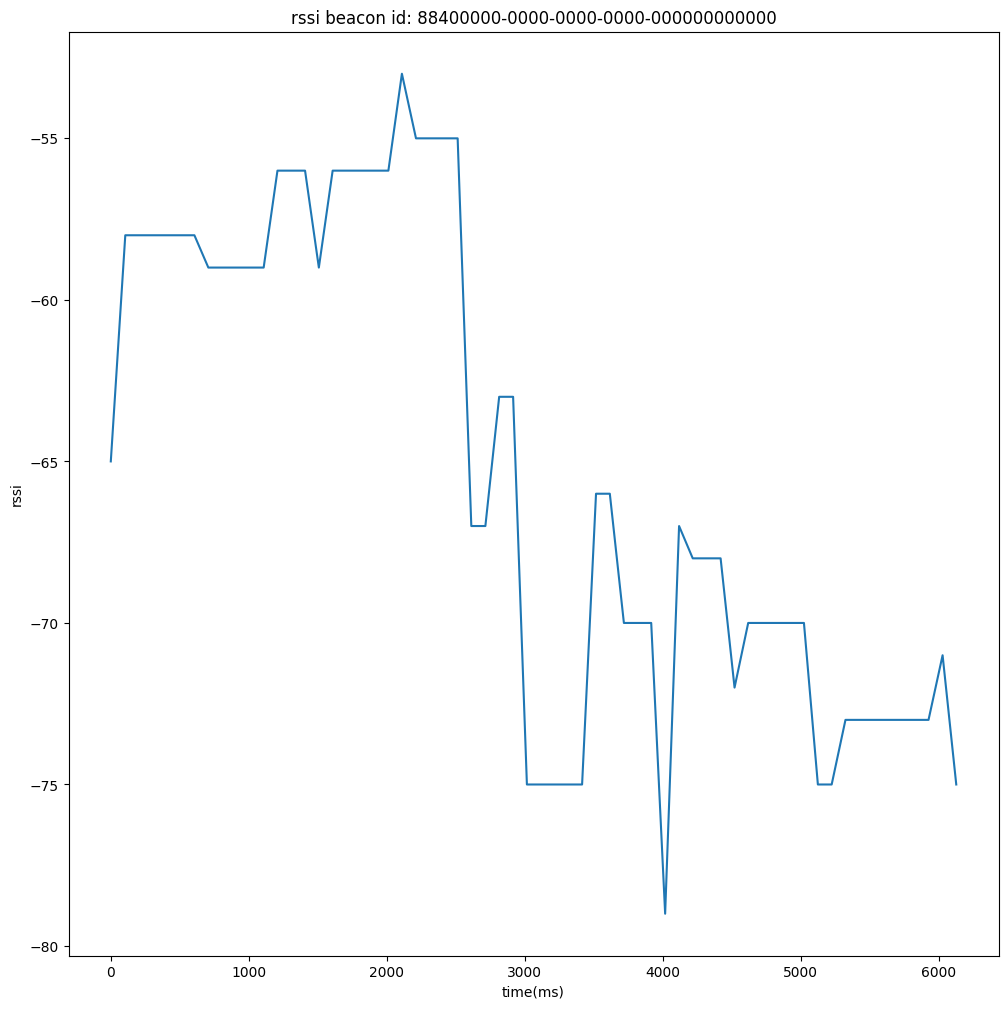

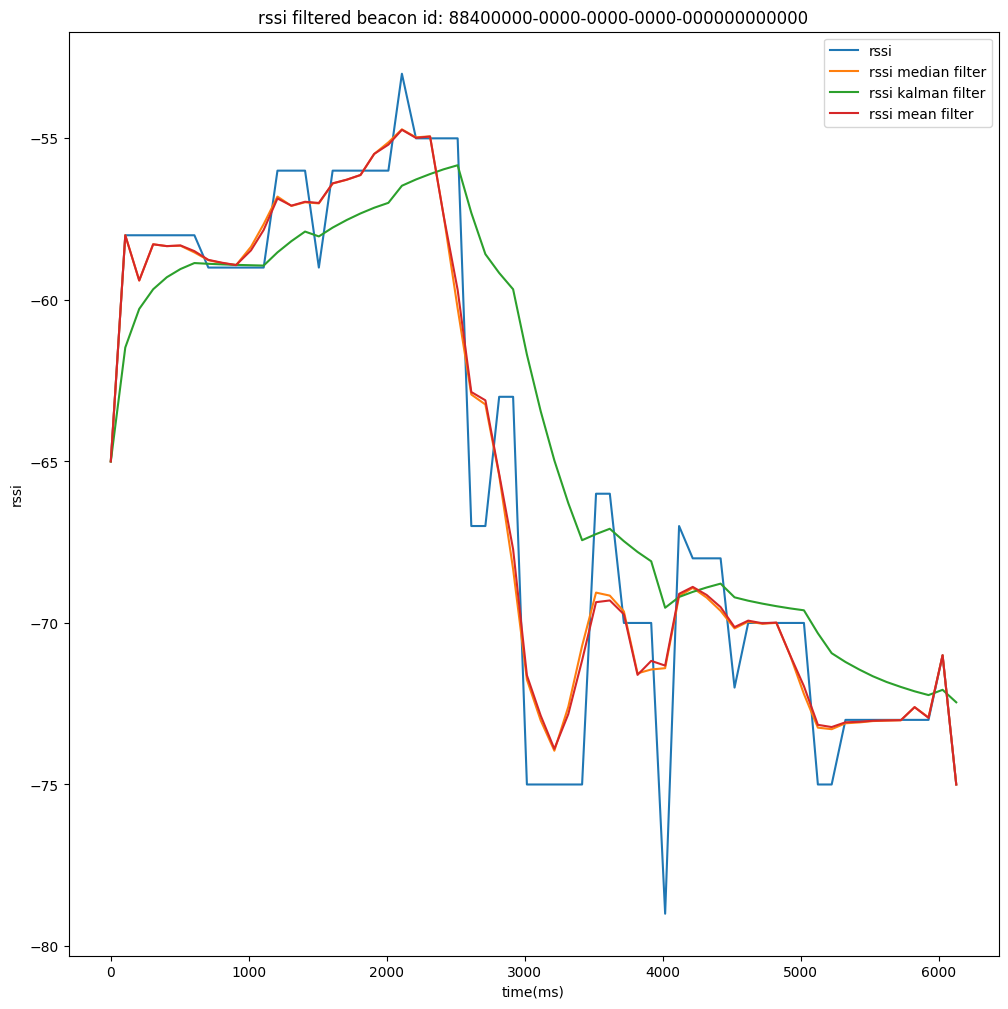

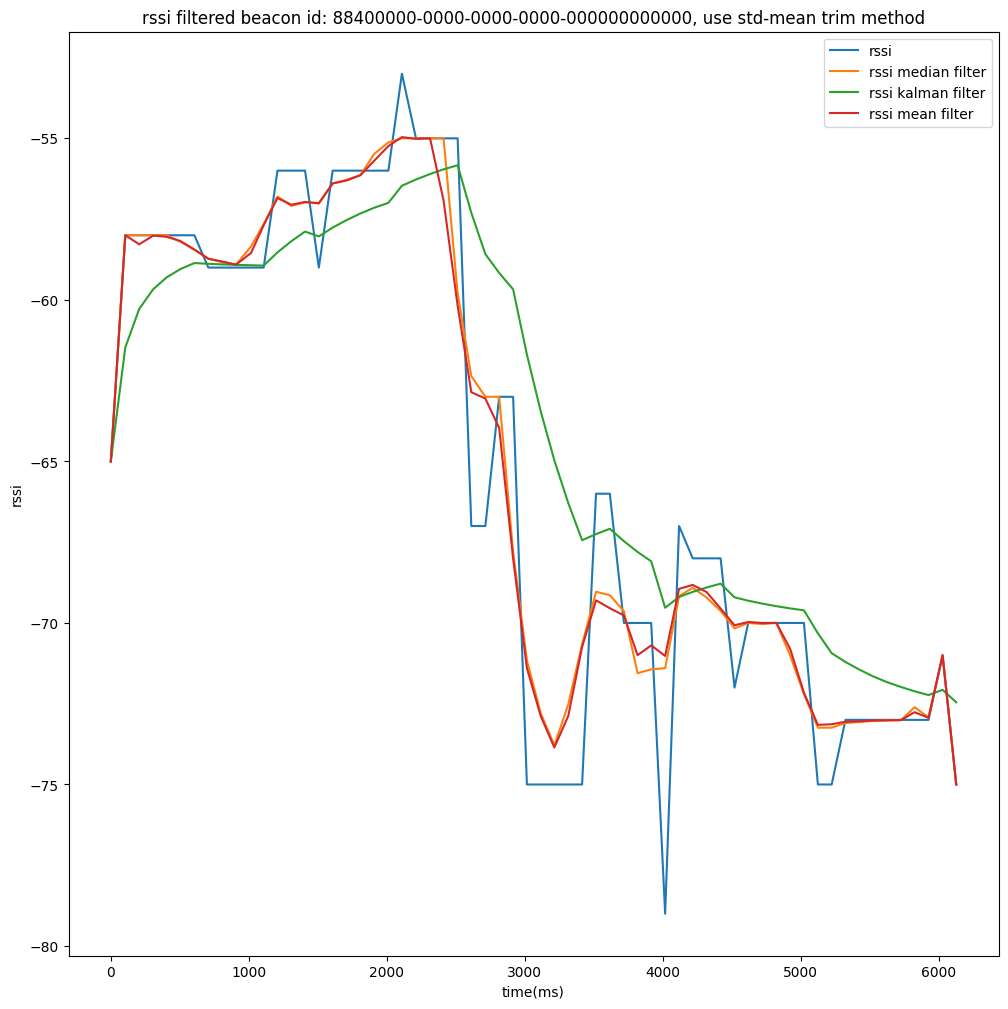

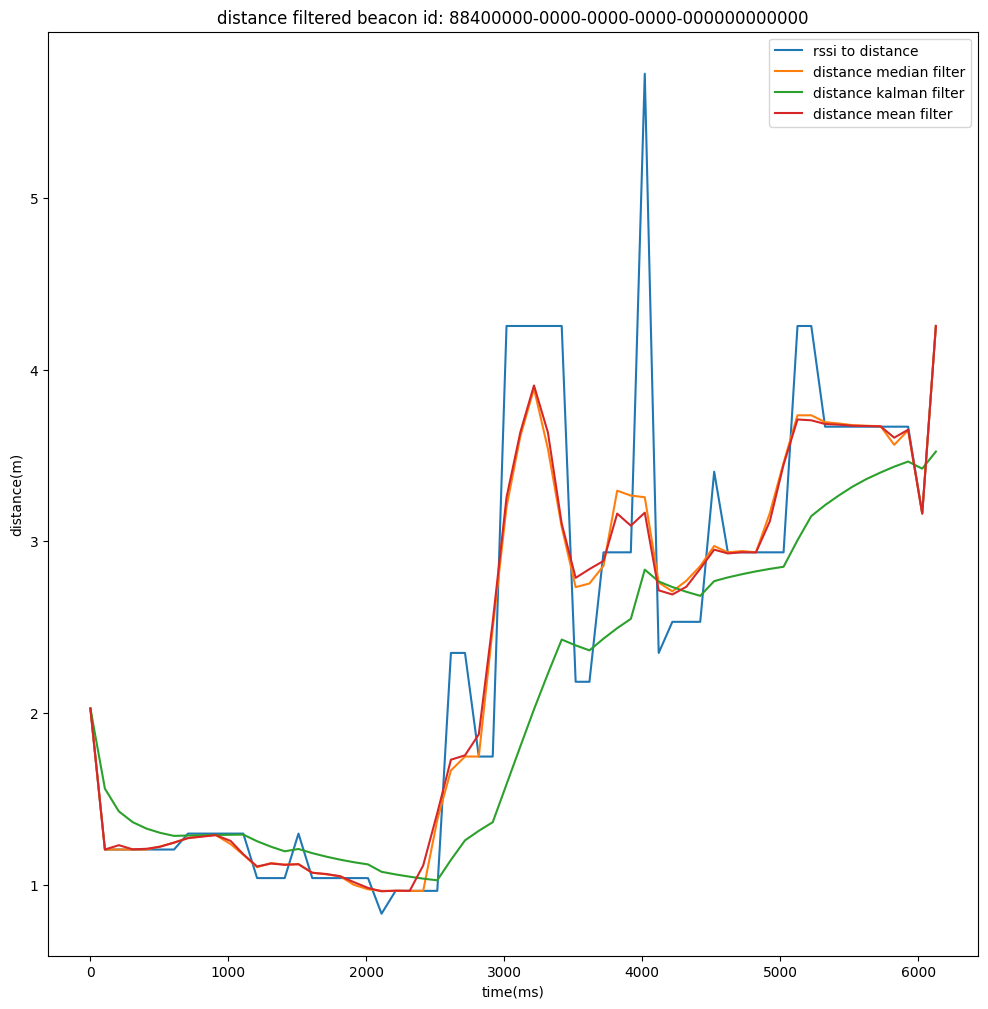

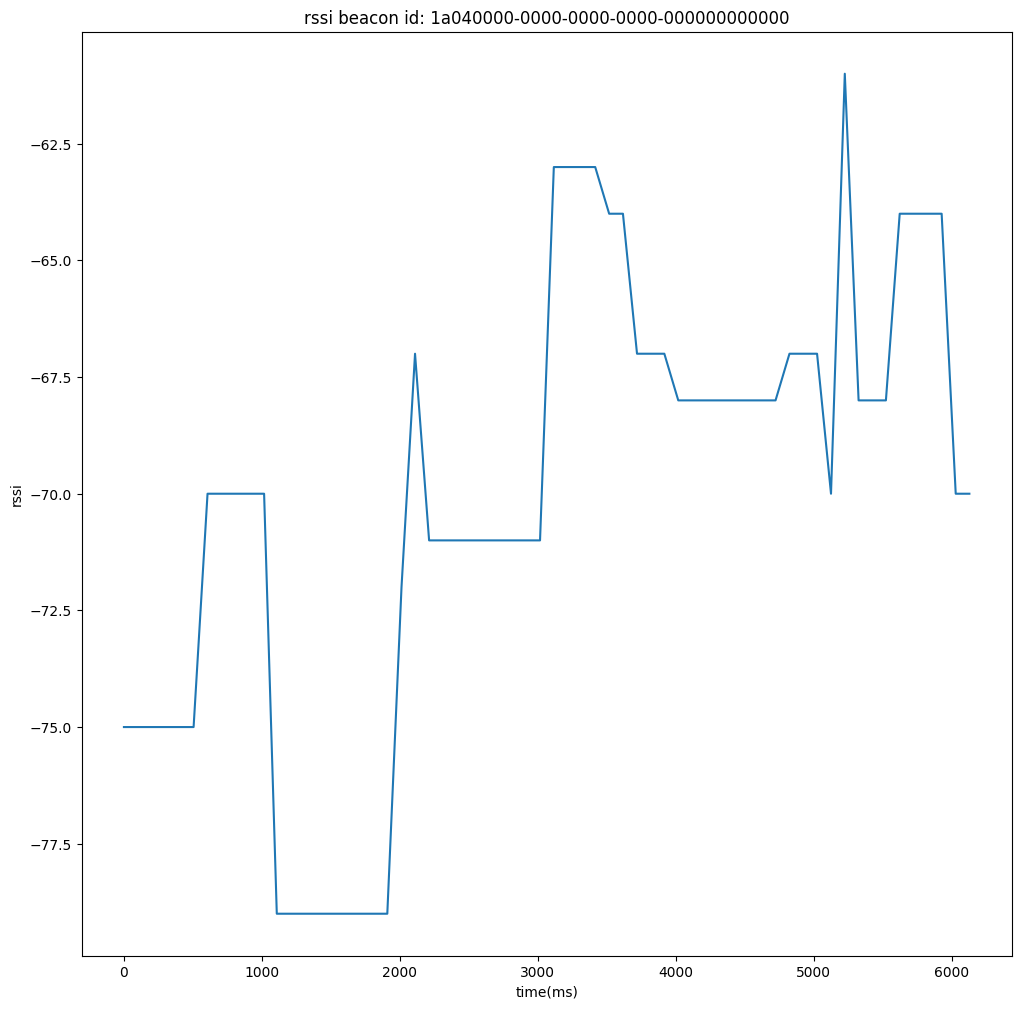

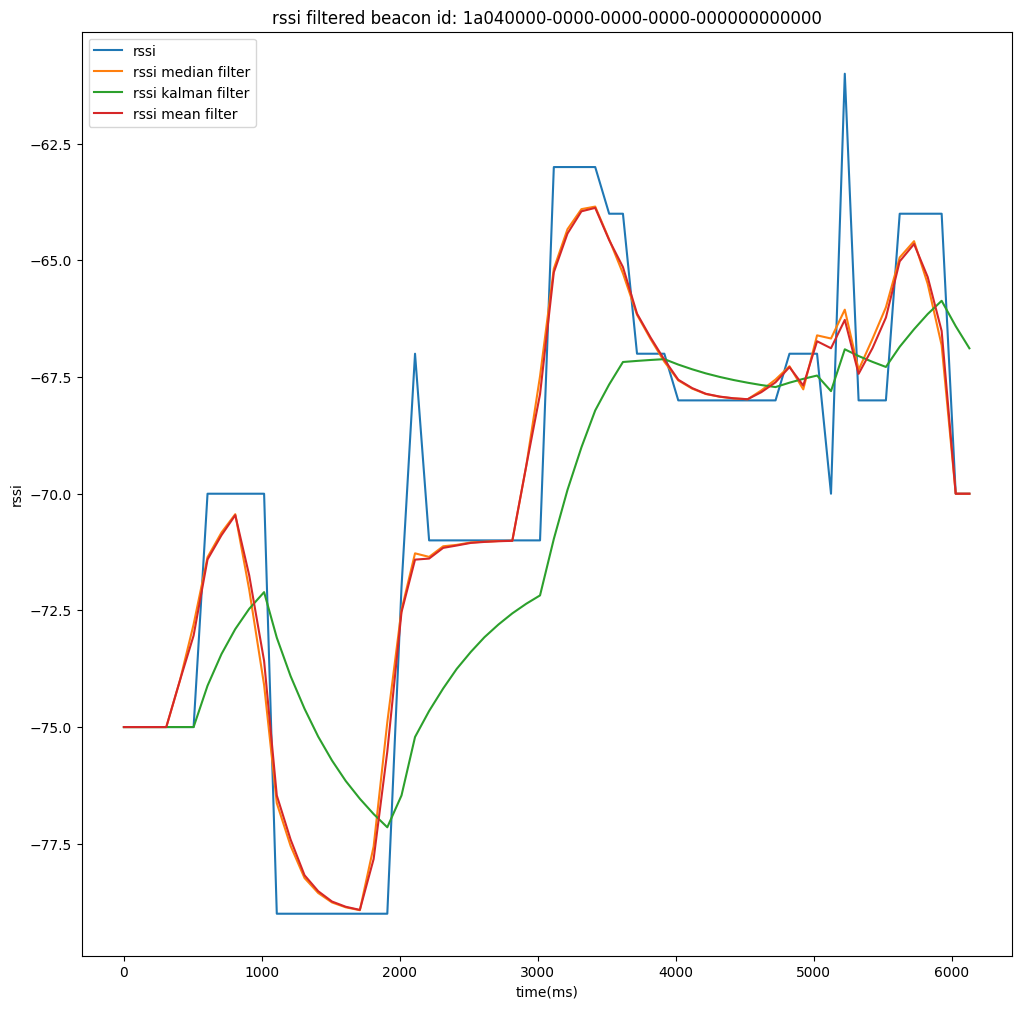

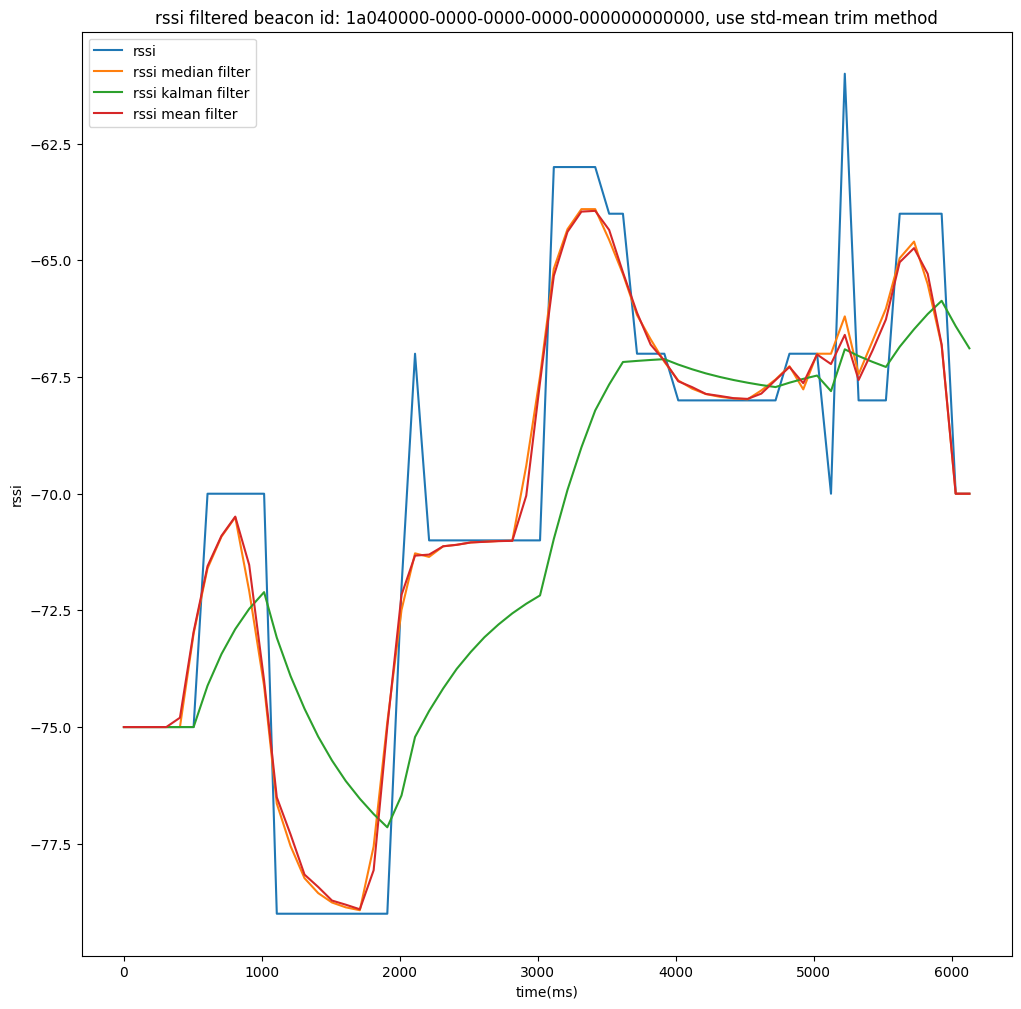

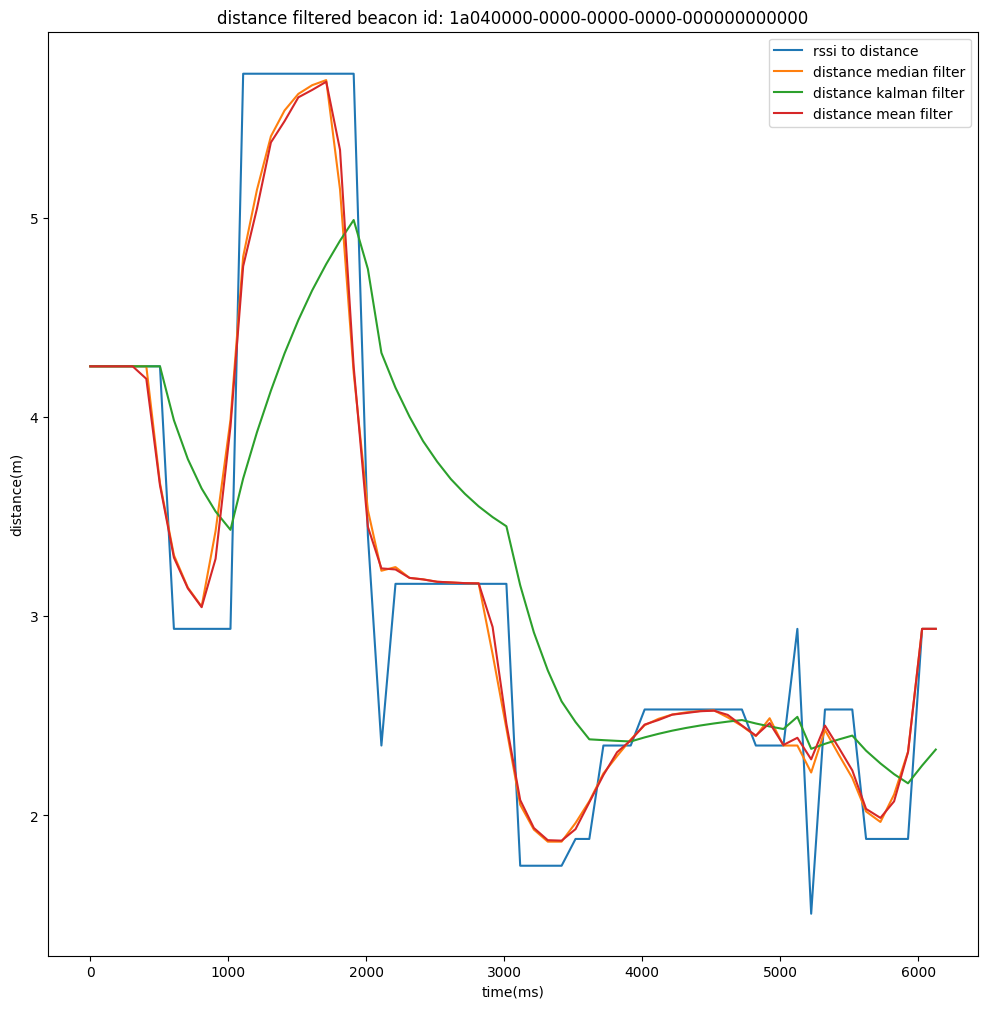

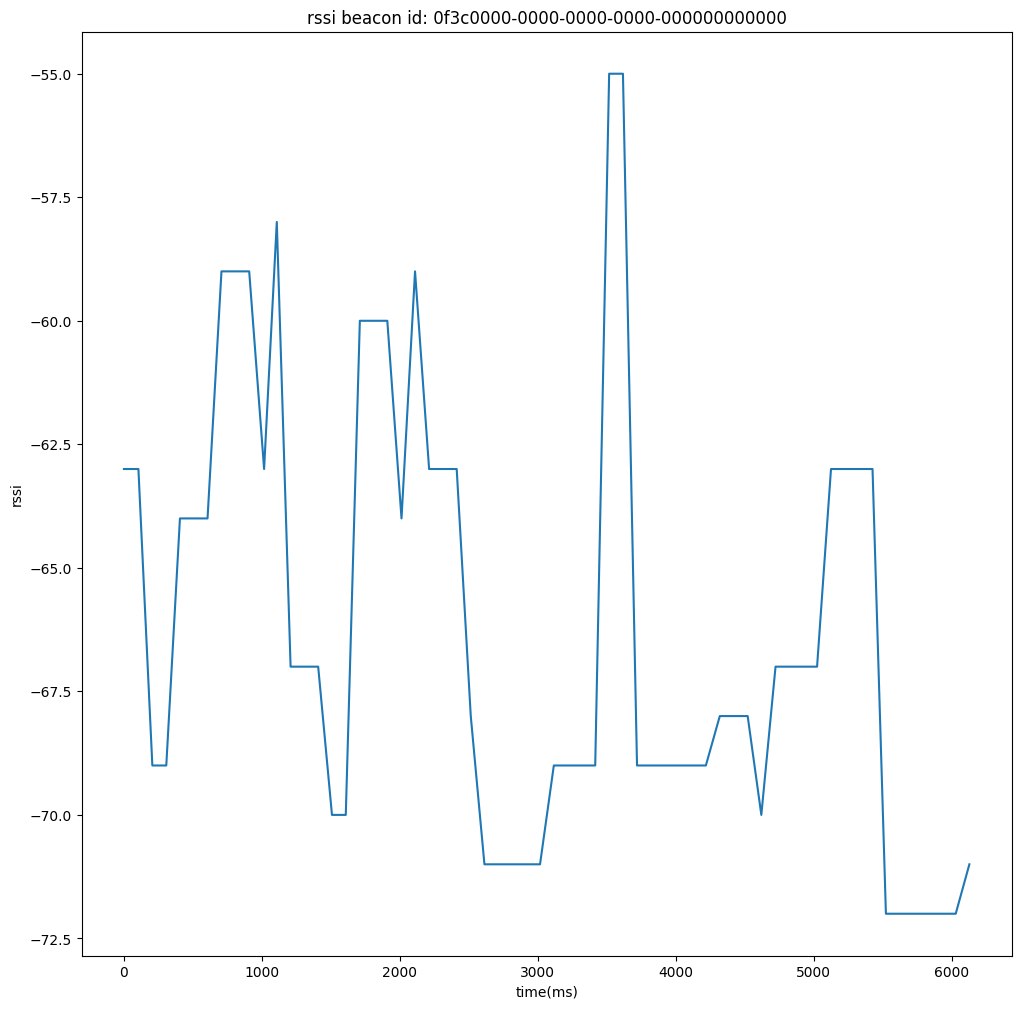

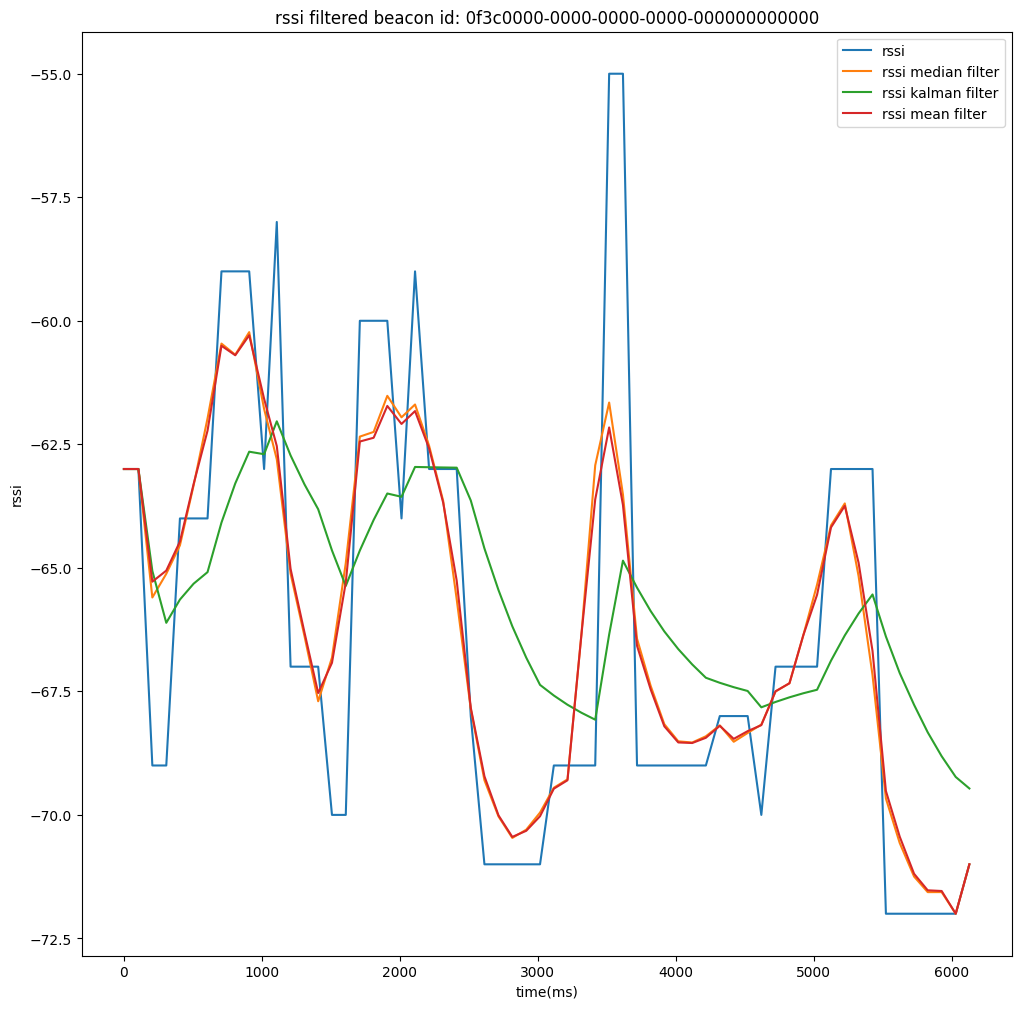

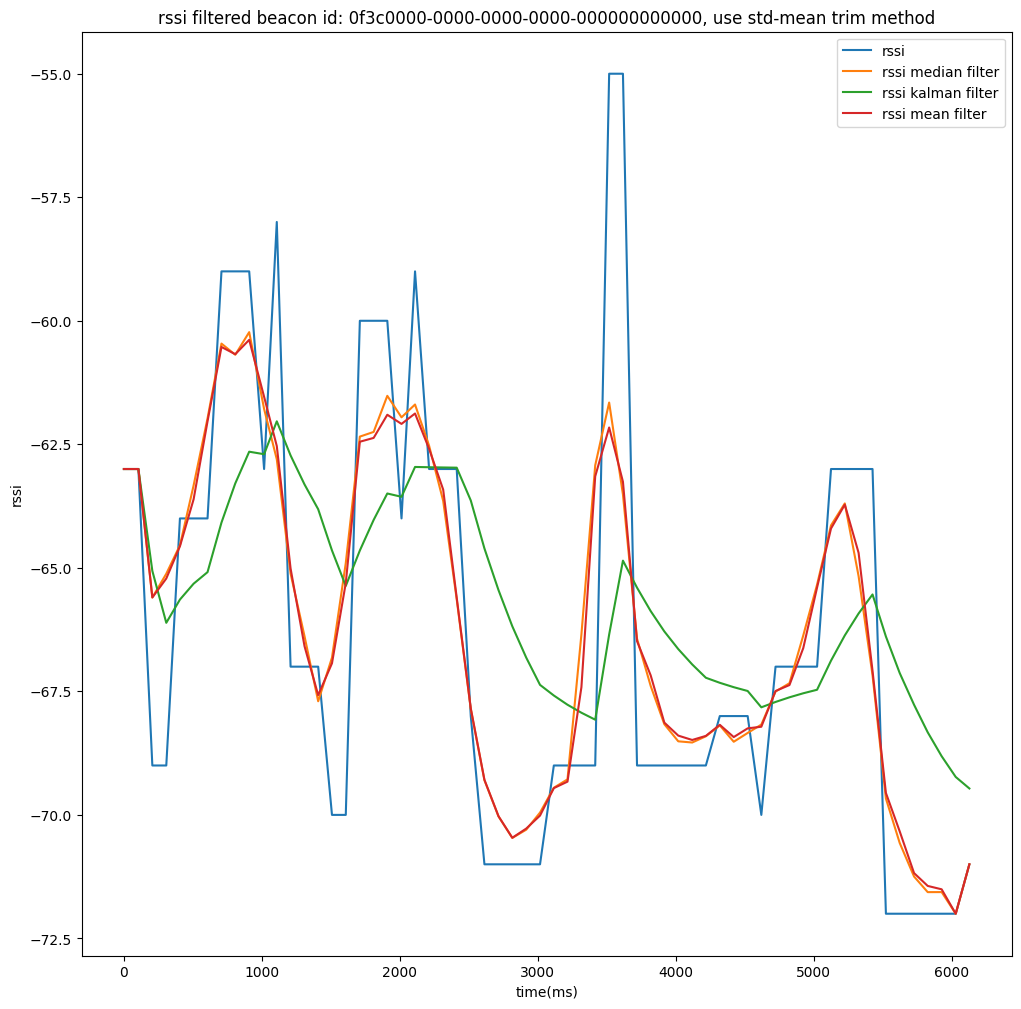

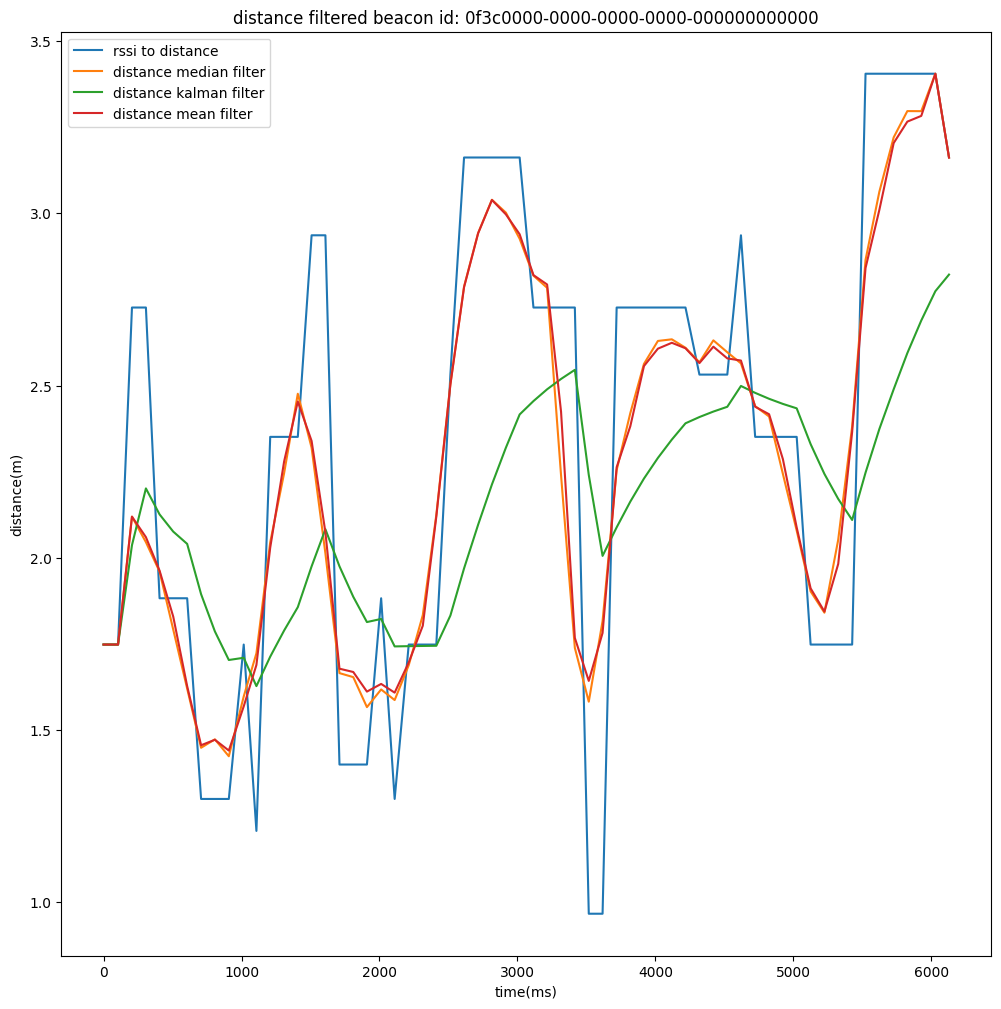

In [2]:

args = argparse.Namespace(beacon_coords_file='../datas/data0830p1/beacon_coords.txt', beacon_data_dir='../datas/data0830p1/', beacon_data_file='../datas/data0830p1/bluetoothData(88).txt', update_frequency=10)

beacon_data = read_beacon_data(args.beacon_data_file)

def remove_outliers(data, threshold=0.5):
    mean = np.mean(data)
    std = np.std(data)
    return [x if abs(x - mean) <= threshold * std else mean for x in data]

def remove_max_min(data):
    sorted_data = sorted(data)
    max_data = sorted_data[-2:]
    min_data = sorted_data[:2]
    mean = np.mean(sorted_data)
    return [x if x not in max_data and x not in min_data else mean for x in data]

def apply_average_filter(data, remove_f, window_size=5):
    filtered_data = data.copy()
    for i in range(len(filtered_data)-window_size+1):
        trimmed_data = remove_f(filtered_data[i:i+window_size])
        filtered_data[i+window_size//2] = np.mean(trimmed_data)
    return filtered_data

def apply_median_filter(data, remove_f, window_size=5):
    filtered_data = data.copy()
    for i in range(len(filtered_data)-window_size+1):
        trimmed_data = remove_f(filtered_data[i:i+window_size])
        filtered_data[i+window_size//2] = np.median(trimmed_data)
    return filtered_data

def apply_kalman_filter(data):
    # data = remove_outliers(data)
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([data[0]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = 0.1
    kf.H = np.array([[1.]])
    kf.F = np.array([[1.]])
    
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return filtered_data

def rssi_to_distance(rssi):
    txPower = -55.47
    n = 3.106
    return 10 ** ((txPower - rssi) / (10 * n))



x0, y0 = 3.0, -1.6
v = 0.00056


beacon_id_to_rssi = defaultdict(list)
time_stamp = []
print(beacon_data)
for beacon_group in beacon_data:
    if len(beacon_group) < 3:
        print("beacon group length is less than 3")
        continue
    for beacon in beacon_group:
        beacon_id = beacon['uuid']
        beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
    time_stamp.append(beacon['time'])

time_stamp = np.array(time_stamp) - time_stamp[0]
d1 = np.sqrt(x0**2 + (y0 + v * time_stamp)**2 + 1.0)
d2 = np.sqrt(x0**2 + (6.0 -y0 - v * time_stamp)**2 + 1.0)
d3 = np.sqrt((x0 - 6.0)**2 + (3 - y0 - v * time_stamp)**2 + 1.0)
ds = [d1, d2, d3]
print("total time interval: ", time_stamp[-1] - time_stamp[0])
for i, (beacon_id, rssi_values) in enumerate(beacon_id_to_rssi.items()):
    if len(beacon_group[0]) <= 3:
        print("beacon group length is less than 3")
        continue
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, rssi_values)
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.title('rssi beacon id: {}'.format(beacon_id))
    plt.show()
    
    distance = [rssi_to_distance(rssi) for rssi in rssi_values]
    rssi_median_filtered = apply_median_filter(rssi_values, remove_max_min)
    rssi_kalman_filtered = apply_kalman_filter(rssi_values)
    rssi_mean_filtered = apply_average_filter(rssi_values, remove_max_min)
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, rssi_values, label='rssi')
    plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    plt.plot(time_stamp, rssi_mean_filtered, label='rssi mean filter')
    # plt.plot(time_stamp, d, label='real distance')
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.legend()
    plt.title('rssi filtered beacon id: {}'.format(beacon_id))
    plt.show()
    
    rssi_median_filtered = apply_median_filter(rssi_values, remove_outliers)
    rssi_mean_filtered = apply_average_filter(rssi_values, remove_outliers)
    rssi_kalman_filtered = apply_kalman_filter(rssi_values) 
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, rssi_values, label='rssi')
    plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    plt.plot(time_stamp, rssi_mean_filtered, label='rssi mean filter')
    # plt.plot(time_stamp, d, label='real distance')
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.legend()
    plt.title('rssi filtered beacon id: {}, use std-mean trim method'.format(beacon_id))
    plt.show() 
    
    
    distance_median_filtered = [rssi_to_distance(rssi) for rssi in rssi_median_filtered]
    distance_kalman_filtered = [rssi_to_distance(rssi) for rssi in rssi_kalman_filtered]
    distance_mean_filtered = [rssi_to_distance(rssi) for rssi in rssi_mean_filtered]
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, distance, label='rssi to distance')
    plt.plot(time_stamp, distance_median_filtered, label='distance median filter')
    plt.plot(time_stamp, distance_kalman_filtered, label='distance kalman filter')
    plt.plot(time_stamp, distance_mean_filtered, label='distance mean filter')
    # plt.plot(time_stamp, ds[i], label='real distance')
    plt.xlabel('time(ms)')
    plt.ylabel('distance(m)')
    plt.title('distance filtered beacon id: {}'.format(beacon_id))
    plt.legend()
    plt.show()


In [3]:
from utils.common import aggregate_continuous_points_sliding, aggregate_continuous_points
import re


args = argparse.Namespace(beacon_coords_file='../datas/data0830p1/beacon_coords.txt', beacon_data_dir='../datas/data0830p1/', beacon_data_file='', update_frequency=10)

files = []
for file in os.listdir(args.beacon_data_dir):
    if re.match(r'bluetoothData\(\d+\).txt', file):
        files.append(file)

positionss = []
for beacon_data_file in files:
    args.beacon_data_file = args.beacon_data_dir + beacon_data_file
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    beacon_data = read_beacon_data(args.beacon_data_file)
    print("beacon data",beacon_data)
    print("beacon group num", len(beacon_data))
    print("beacon data file", args.beacon_data_file)

    positions = process_beacon_data_for_pos(args)
    positions = [pos[:3] for pos in positions if pos is not None]
    positionss.append(positions)

beacon data [[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -59, 'accuracy': 7.721894863531677, 'time': 1724997649446}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724997649446}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -59, 'accuracy': 7.721894863531677, 'time': 1724997649542}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724997649542}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -65, 'accuracy': 19.345173789319468, 'time': 1724997649640}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -75, 'accuracy': 78.58155583957935, 'time': 1724997649640}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1724997649640}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -58, 'accuracy': 6.60036888795063, 'time': 1724997649745}, {'uuid': '1a040000-0000-0000-0000-0000000

position [[1.91369563]
 [1.28360312]
 [0.90081114]]
position [[1.97071193]
 [1.30321228]
 [0.90485424]]
position [[1.89101267]
 [1.53929708]
 [0.9068232 ]]
position [[1.95328234]
 [1.72906242]
 [0.90760256]]
position [[1.99585945]
 [1.85173867]
 [0.9077226 ]]
position [[2.0248433 ]
 [1.9299639 ]
 [0.90749598]]
position [[1.97328207]
 [1.96315241]
 [0.90708875]]
position [[2.2456368 ]
 [1.63625723]
 [0.90660437]]
position [[2.21632654]
 [1.27421313]
 [0.90609242]]
position [[2.19477081]
 [1.02292038]
 [0.90558446]]
position [[2.17876064]
 [0.84906414]
 [0.90509488]]
position [[2.12528108]
 [0.68539578]
 [0.90463382]]
position [[2.04277202]
 [0.56388325]
 [0.9042039 ]]
position [[2.20459363]
 [0.62385918]
 [0.90380715]]
position [[2.31949292]
 [0.67015747]
 [0.90344247]]
position [[2.4006255 ]
 [0.70618199]
 [0.90311048]]
position [[2.23116002]
 [0.99127106]
 [0.90280581]]
position [[2.0986679 ]
 [1.32137036]
 [0.90253027]]
position [[2.00797006]
 [1.46291143]
 [0.90227983]]
position [[1

KeyboardInterrupt: 

len positions 62
positions [array([[2.2272551],
       [1.4577365],
       [0.818919 ]]), array([[2.18143193],
       [1.41386708],
       [0.86167725]]), array([[1.9713605 ],
       [1.31894523],
       [0.88121472]]), array([[1.83720429],
       [1.25850644],
       [0.89337789]]), array([[1.9136109 ],
       [1.28354301],
       [0.90074375]]), array([[1.97064863],
       [1.30316146],
       [0.9047962 ]]), array([[1.89094122],
       [1.53931554],
       [0.9067714 ]]), array([[1.95323801],
       [1.72909979],
       [0.9075565 ]]), array([[1.99582803],
       [1.85177559],
       [0.9076823 ]]), array([[2.02481731],
       [1.92996623],
       [0.90745943]]), array([[1.97325775],
       [1.96316982],
       [0.90705797]]), array([[2.24563805],
       [1.63625467],
       [0.90657814]]), array([[2.21632379],
       [1.27418518],
       [0.90606917]]), array([[2.1947693 ],
       [1.02286496],
       [0.90556438]]), array([[2.17875973],
       [0.84897843],
       [0.90507752]]), 

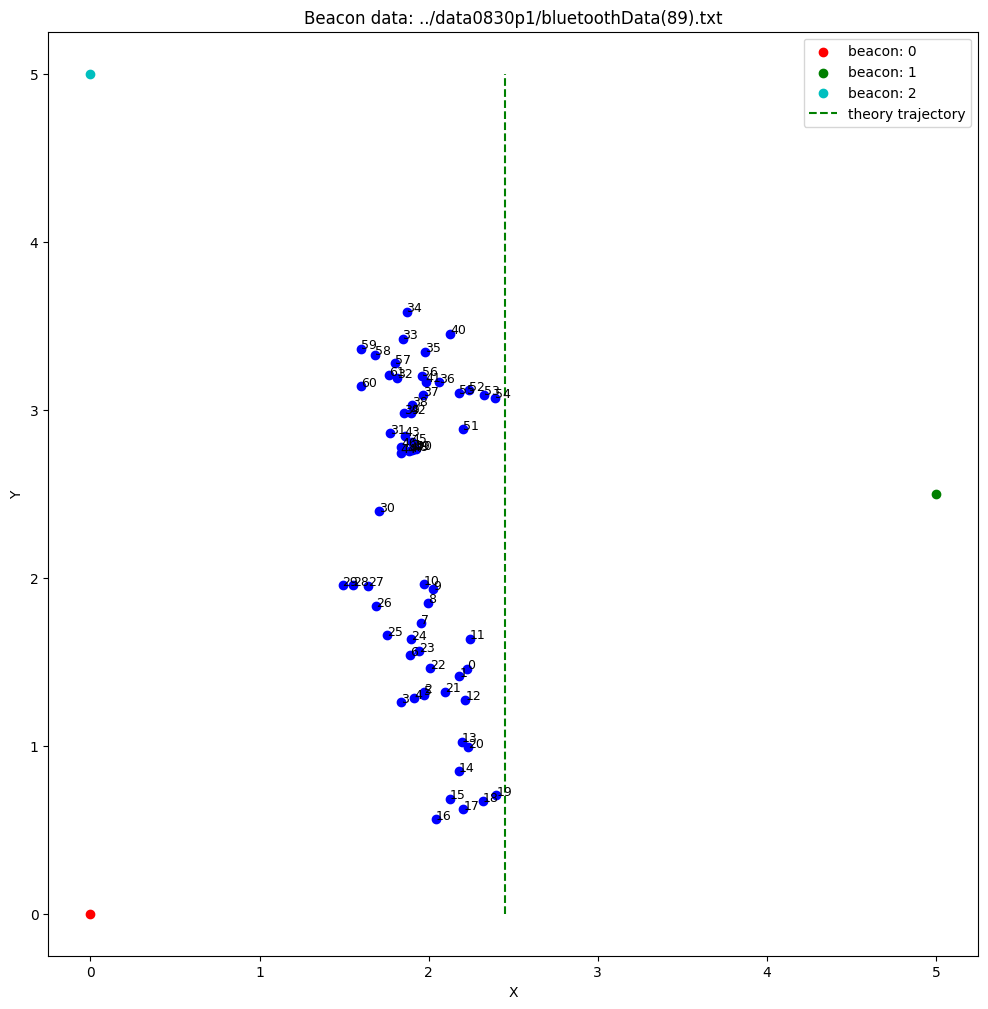

positions [array([[2.2272551],
       [1.4577365],
       [0.818919 ]]), array([[2.18143193],
       [1.41386708],
       [0.86167725]]), array([[1.9713605 ],
       [1.31894523],
       [0.88121472]]), array([[1.83720429],
       [1.25850644],
       [0.89337789]]), array([[1.9136109 ],
       [1.28354301],
       [0.90074375]]), array([[1.97064863],
       [1.30316146],
       [0.9047962 ]]), array([[1.89094122],
       [1.53931554],
       [0.9067714 ]]), array([[1.95323801],
       [1.72909979],
       [0.9075565 ]]), array([[1.99582803],
       [1.85177559],
       [0.9076823 ]]), array([[2.02481731],
       [1.92996623],
       [0.90745943]]), array([[1.97325775],
       [1.96316982],
       [0.90705797]]), array([[2.24563805],
       [1.63625467],
       [0.90657814]]), array([[2.21632379],
       [1.27418518],
       [0.90606917]]), array([[2.1947693 ],
       [1.02286496],
       [0.90556438]]), array([[2.17875973],
       [0.84897843],
       [0.90507752]]), array([[2.1252715

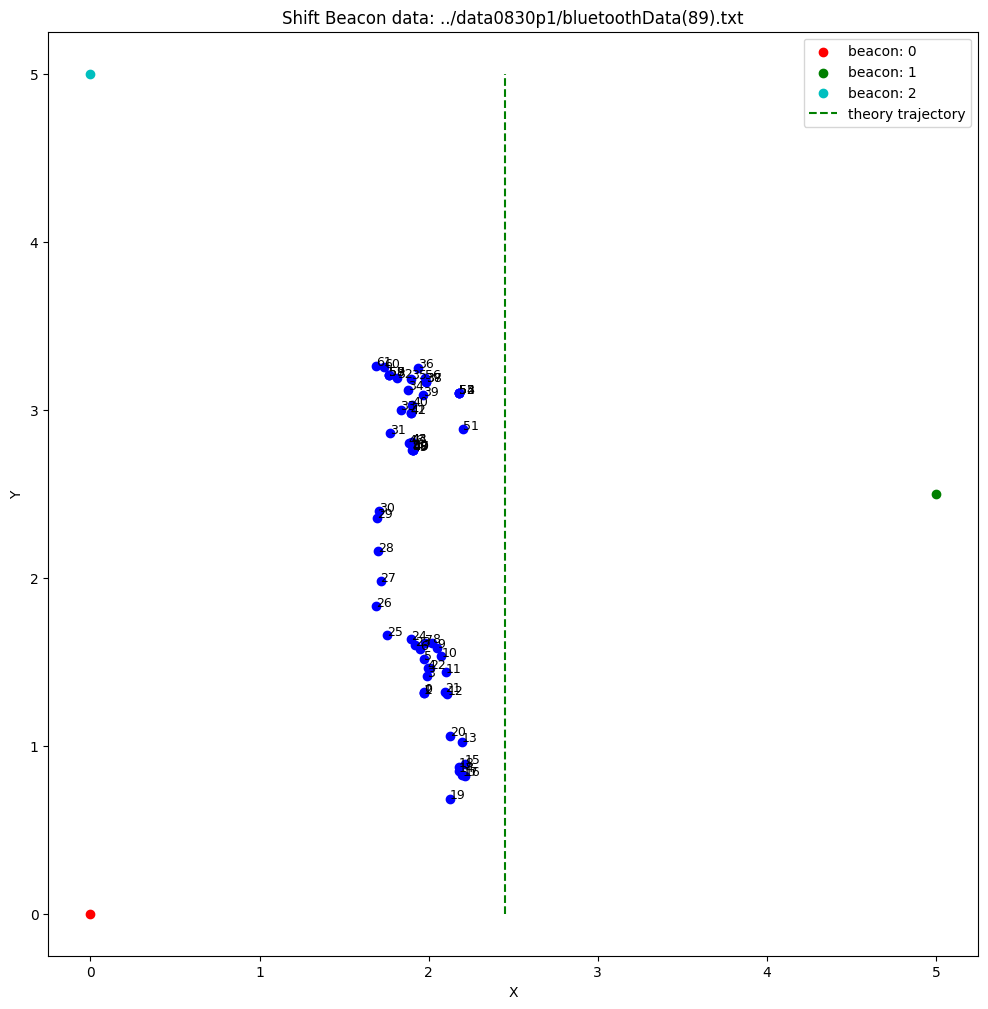

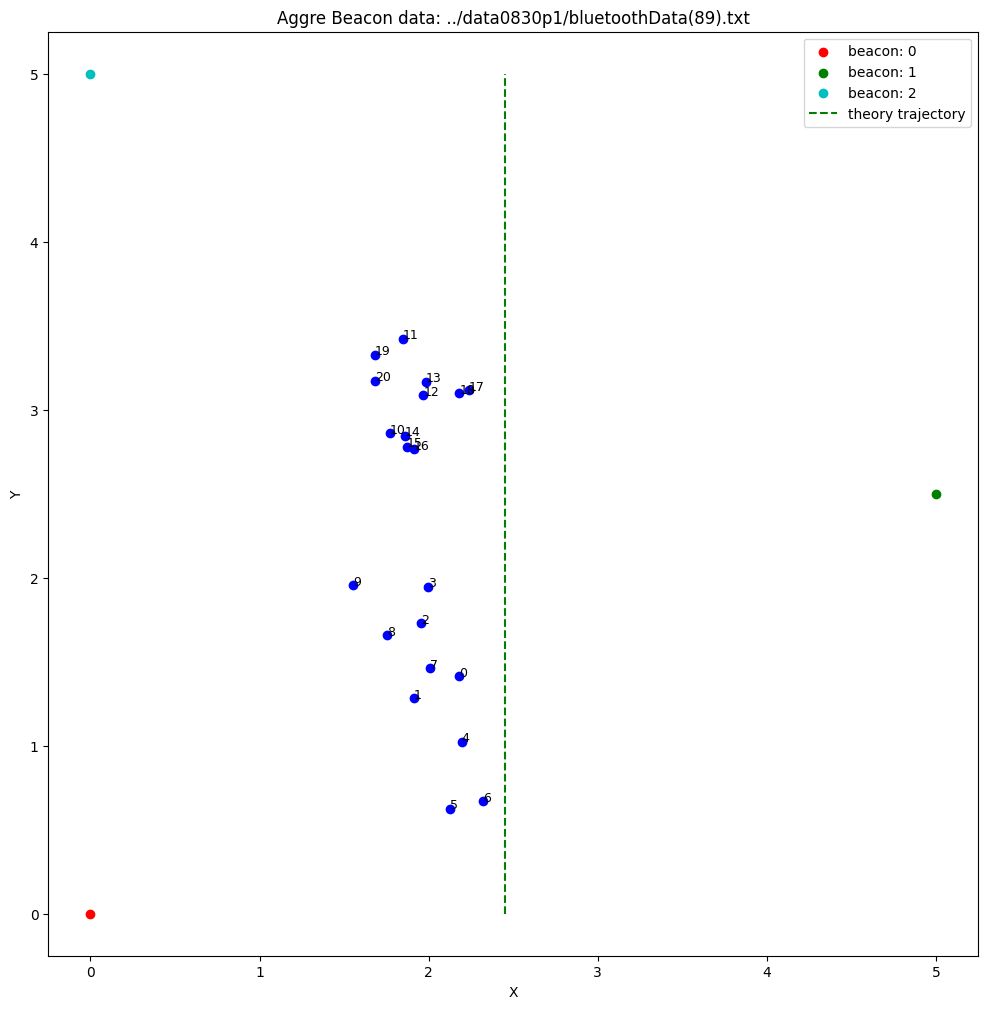

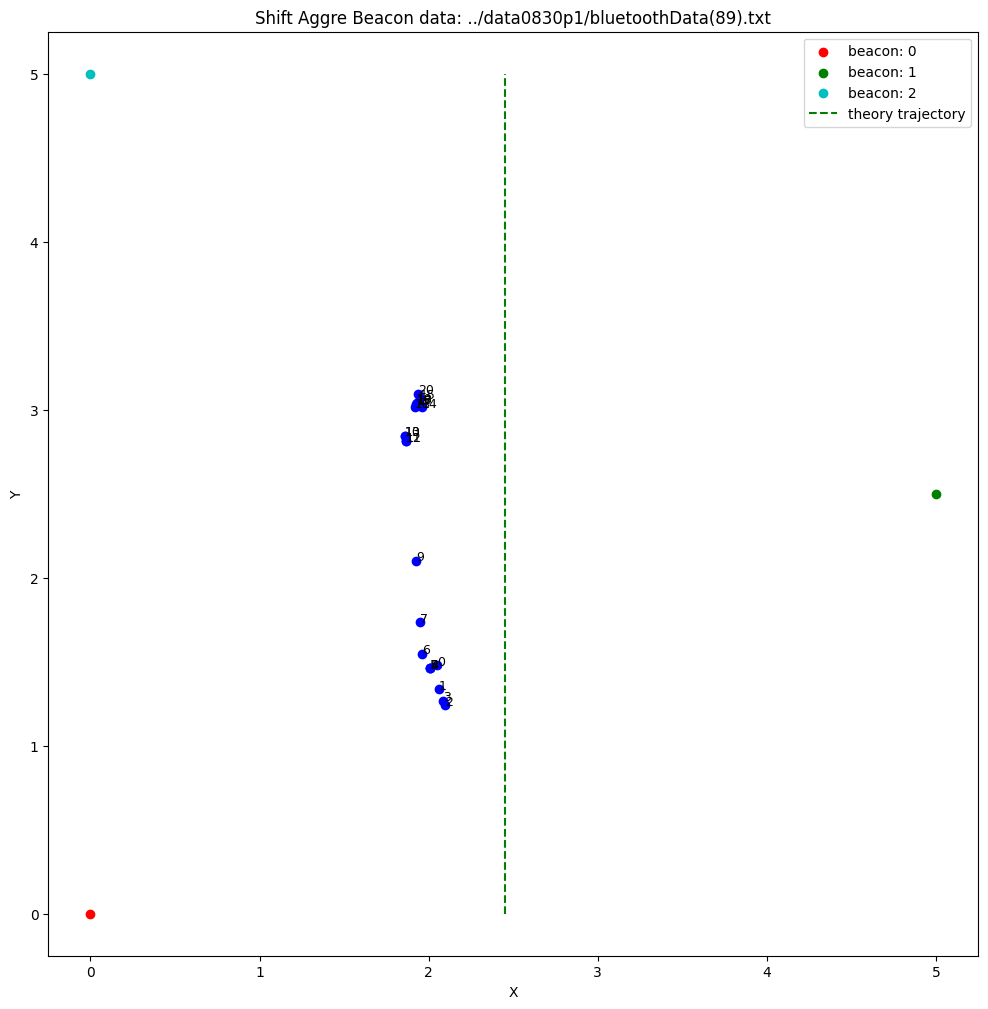

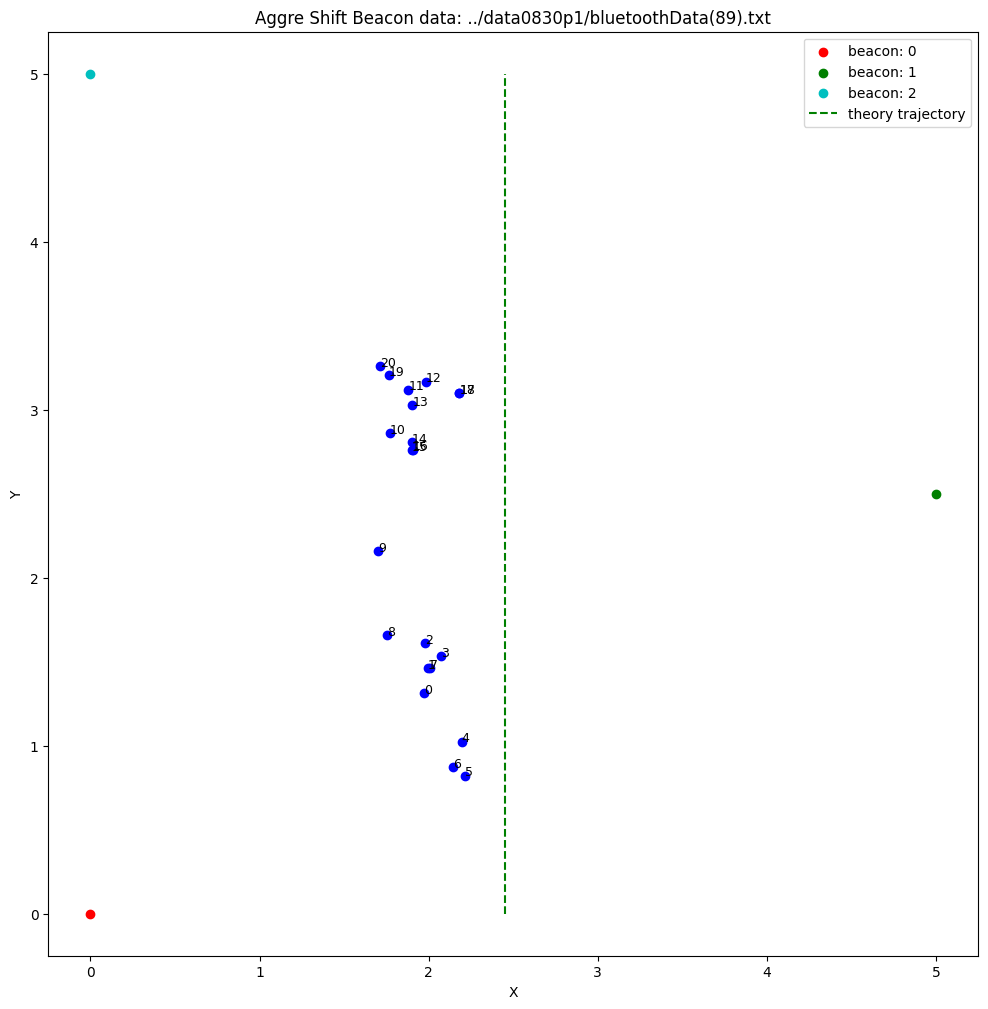

len positions 65
positions [array([[ 2.47291631],
       [-0.06362352],
       [ 0.81891901]]), array([[ 2.60206917],
       [-0.06694638],
       [ 0.86168865]]), array([[ 2.66110671],
       [-0.06846531],
       [ 0.88123923]]), array([[ 2.69785714],
       [-0.06941083],
       [ 0.89340933]]), array([[ 2.90954423],
       [-0.49187362],
       [ 0.90077674]]), array([[ 2.5620278 ],
       [-0.55702811],
       [ 0.90483507]]), array([[ 2.32954222],
       [-0.59183411],
       [ 0.90679625]]), array([[ 2.17833677],
       [-0.60904186],
       [ 0.90760572]]), array([[ 2.33020164],
       [-0.36716164],
       [ 0.90772301]]), array([[ 2.68122975],
       [-0.09648318],
       [ 0.90749432]]), array([[2.89866766],
       [0.06082557],
       [0.9070836 ]]), array([[3.08069428],
       [0.17342416],
       [0.9065928 ]]), array([[3.06435241],
       [0.48671468],
       [0.90607158]]), array([[3.05021735],
       [0.7008271 ],
       [0.90555701]]), array([[2.88138569],
       [0.8

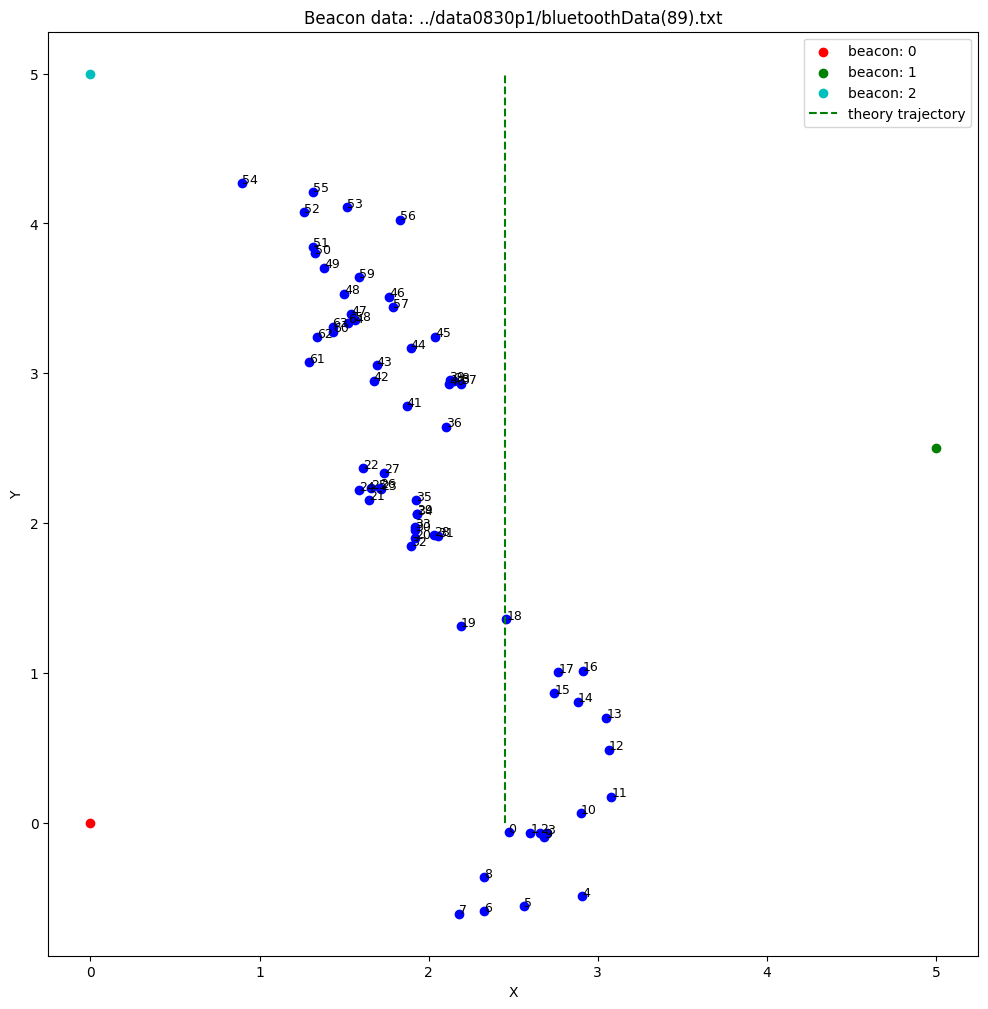

positions [array([[ 2.47291631],
       [-0.06362352],
       [ 0.81891901]]), array([[ 2.60206917],
       [-0.06694638],
       [ 0.86168865]]), array([[ 2.66110671],
       [-0.06846531],
       [ 0.88123923]]), array([[ 2.69785714],
       [-0.06941083],
       [ 0.89340933]]), array([[ 2.90954423],
       [-0.49187362],
       [ 0.90077674]]), array([[ 2.5620278 ],
       [-0.55702811],
       [ 0.90483507]]), array([[ 2.32954222],
       [-0.59183411],
       [ 0.90679625]]), array([[ 2.17833677],
       [-0.60904186],
       [ 0.90760572]]), array([[ 2.33020164],
       [-0.36716164],
       [ 0.90772301]]), array([[ 2.68122975],
       [-0.09648318],
       [ 0.90749432]]), array([[2.89866766],
       [0.06082557],
       [0.9070836 ]]), array([[3.08069428],
       [0.17342416],
       [0.9065928 ]]), array([[3.06435241],
       [0.48671468],
       [0.90607158]]), array([[3.05021735],
       [0.7008271 ],
       [0.90555701]]), array([[2.88138569],
       [0.80647355],
       

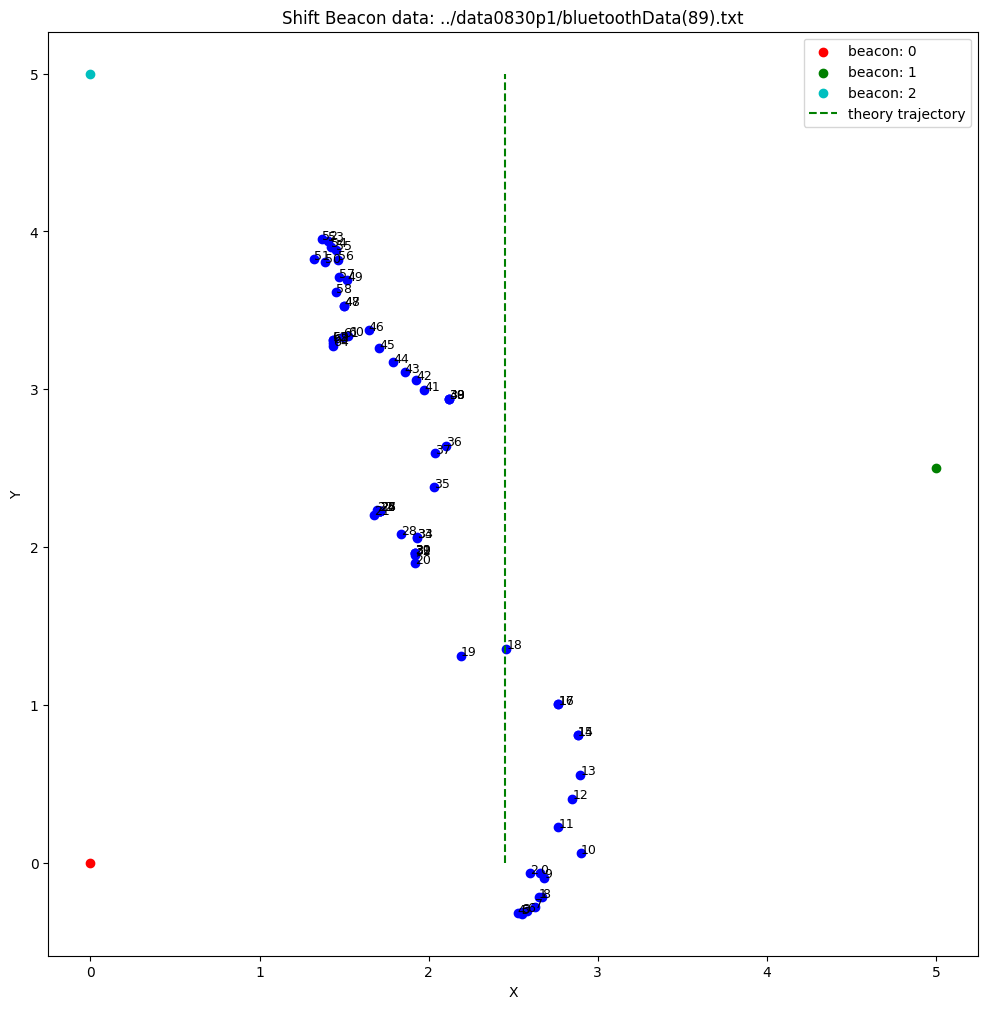

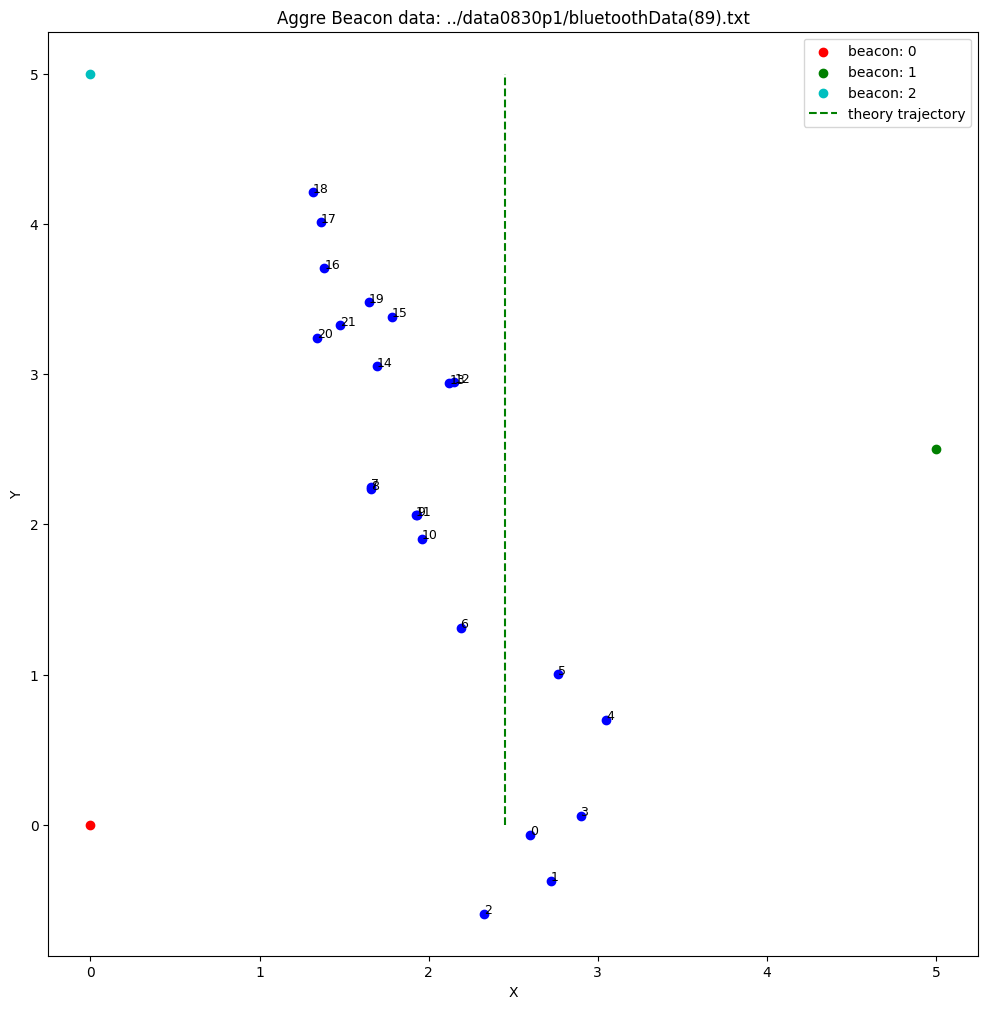

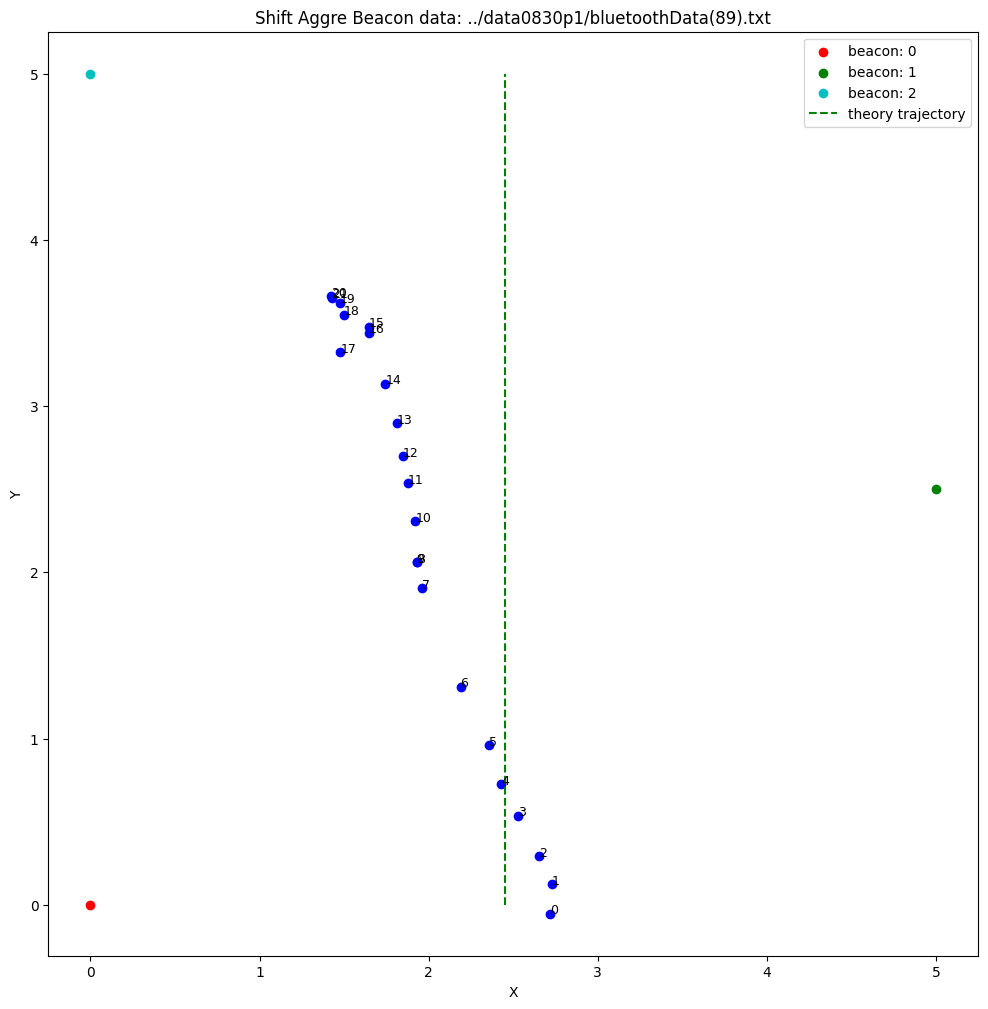

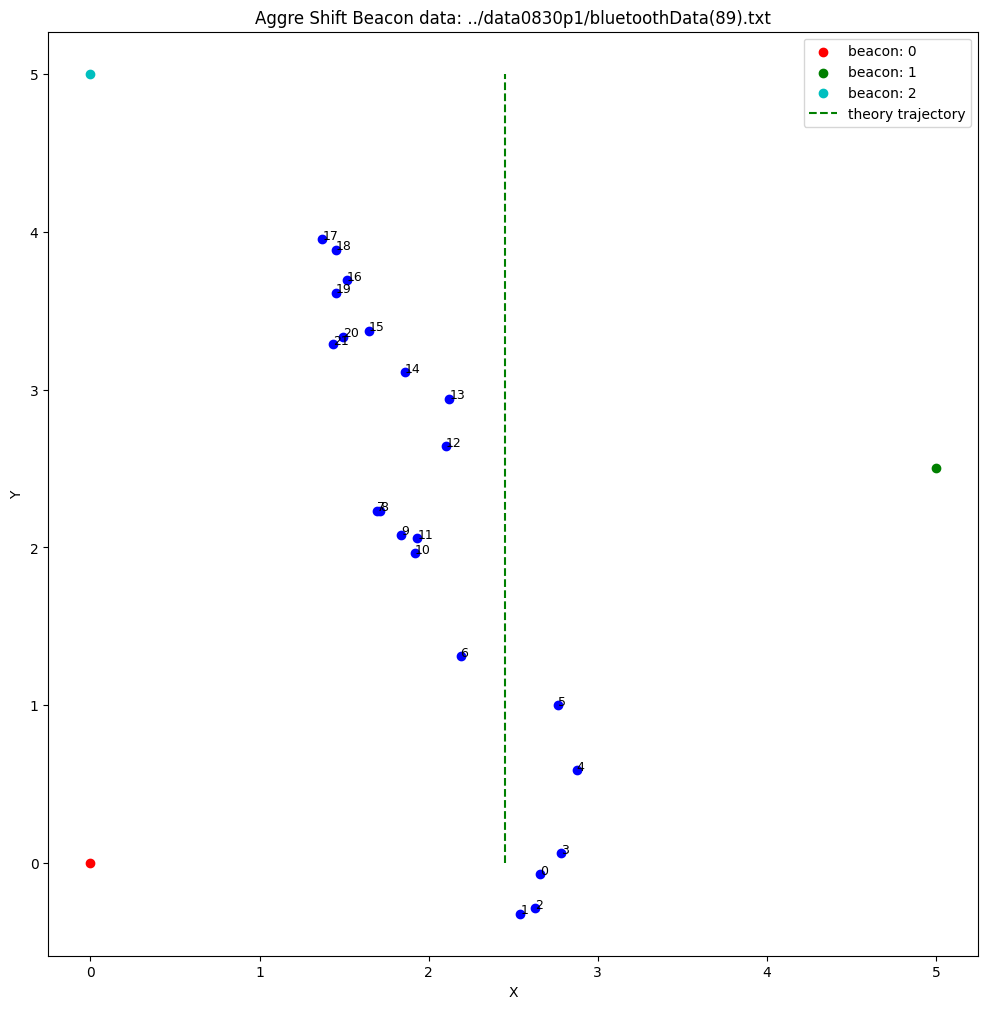

len positions 61
positions [array([[2.3358089 ],
       [0.50734142],
       [0.81891899]]), array([[2.52069679],
       [0.58735268],
       [0.86171173]]), array([[2.52115722],
       [0.55247792],
       [0.8813235 ]]), array([[2.74196022],
       [0.01876561],
       [0.89354541]]), array([[ 3.00704452],
       [-0.20657682],
       [ 0.90086032]]), array([[2.53045788],
       [0.45884061],
       [0.90485942]]), array([[2.3621094 ],
       [0.96293238],
       [0.90681179]]), array([[2.27873276],
       [1.29957791],
       [0.90758155]]), array([[2.4934068 ],
       [0.68637288],
       [0.90773812]]), array([[2.11623572],
       [1.0987353 ],
       [0.90751442]]), array([[1.83026667],
       [1.33769152],
       [0.90711003]]), array([[1.83797349],
       [1.4269407 ],
       [0.90659911]]), array([[1.86550033],
       [1.49618592],
       [0.90607627]]), array([[1.94219034],
       [1.56736789],
       [0.90556286]]), array([[1.87410756],
       [1.67810407],
       [0.9050732

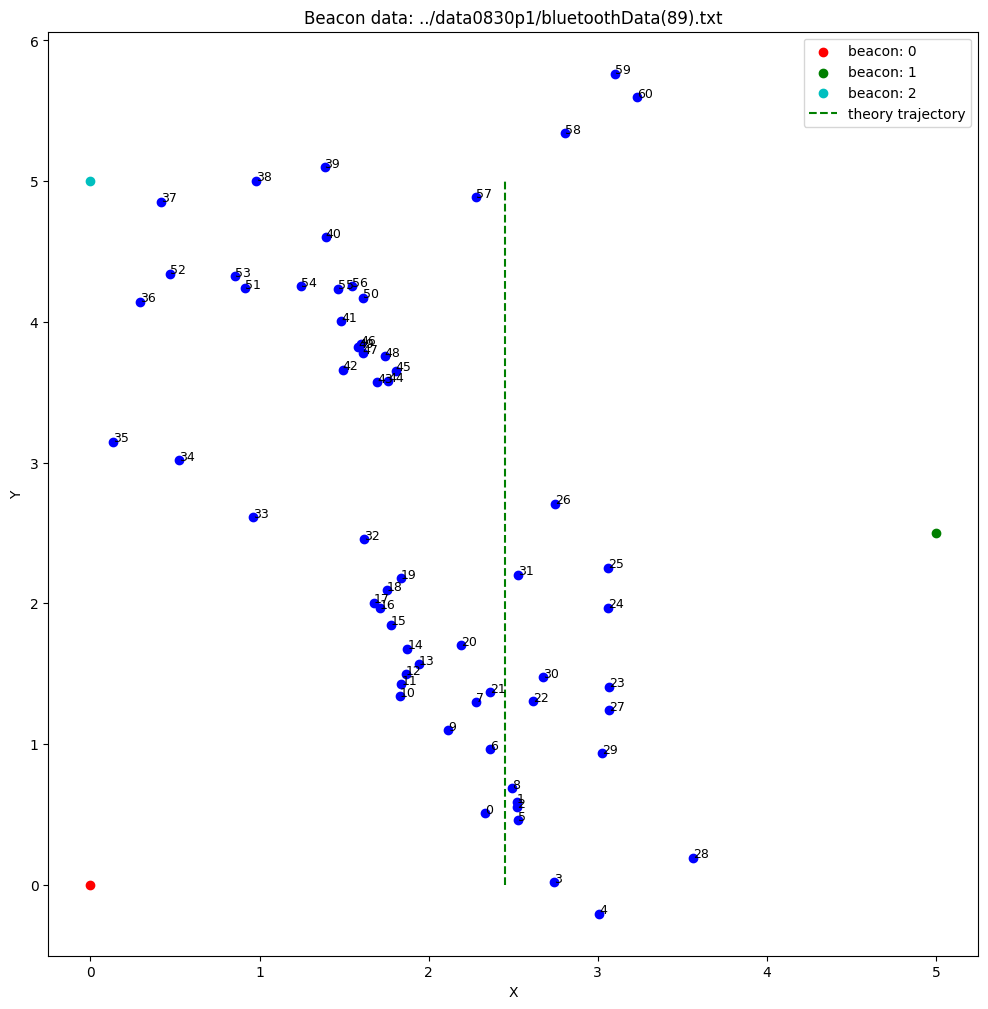

positions [array([[2.3358089 ],
       [0.50734142],
       [0.81891899]]), array([[2.52069679],
       [0.58735268],
       [0.86171173]]), array([[2.52115722],
       [0.55247792],
       [0.8813235 ]]), array([[2.74196022],
       [0.01876561],
       [0.89354541]]), array([[ 3.00704452],
       [-0.20657682],
       [ 0.90086032]]), array([[2.53045788],
       [0.45884061],
       [0.90485942]]), array([[2.3621094 ],
       [0.96293238],
       [0.90681179]]), array([[2.27873276],
       [1.29957791],
       [0.90758155]]), array([[2.4934068 ],
       [0.68637288],
       [0.90773812]]), array([[2.11623572],
       [1.0987353 ],
       [0.90751442]]), array([[1.83026667],
       [1.33769152],
       [0.90711003]]), array([[1.83797349],
       [1.4269407 ],
       [0.90659911]]), array([[1.86550033],
       [1.49618592],
       [0.90607627]]), array([[1.94219034],
       [1.56736789],
       [0.90556286]]), array([[1.87410756],
       [1.67810407],
       [0.90507329]]), array([[1.7

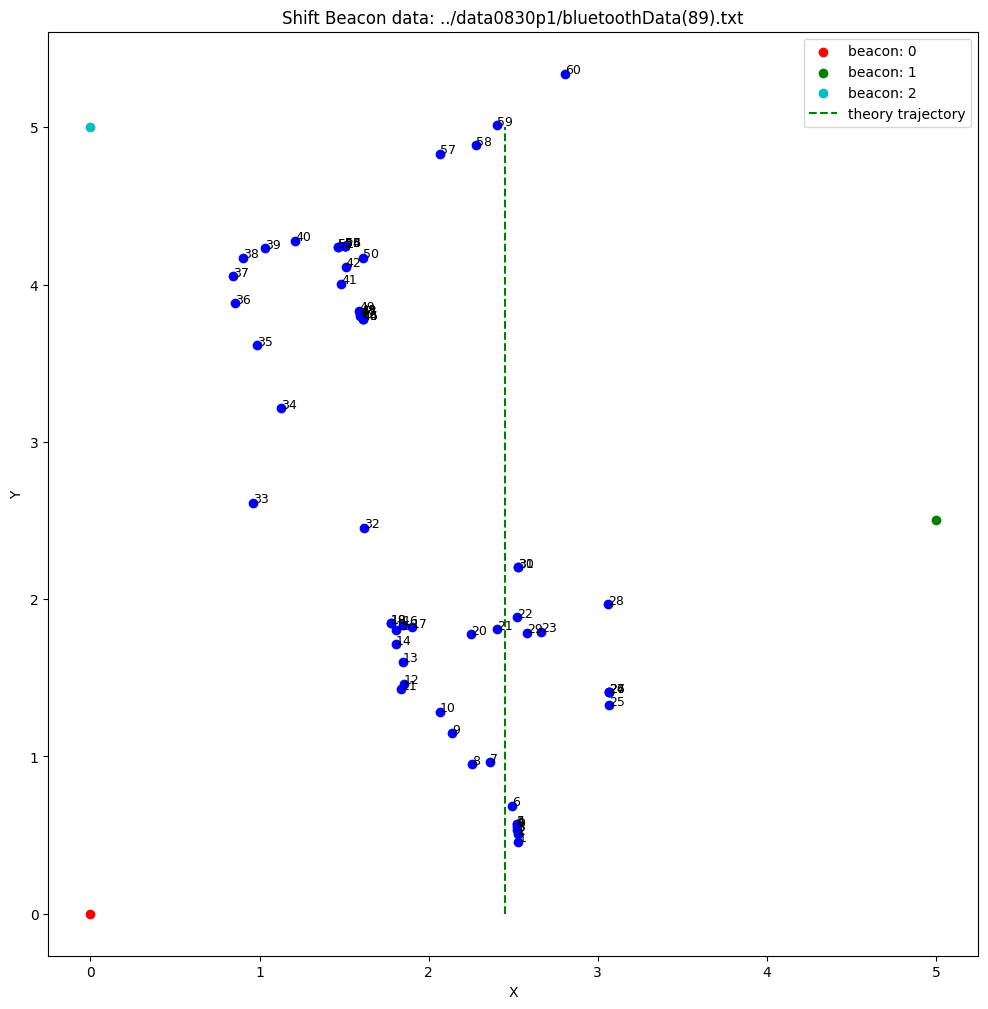

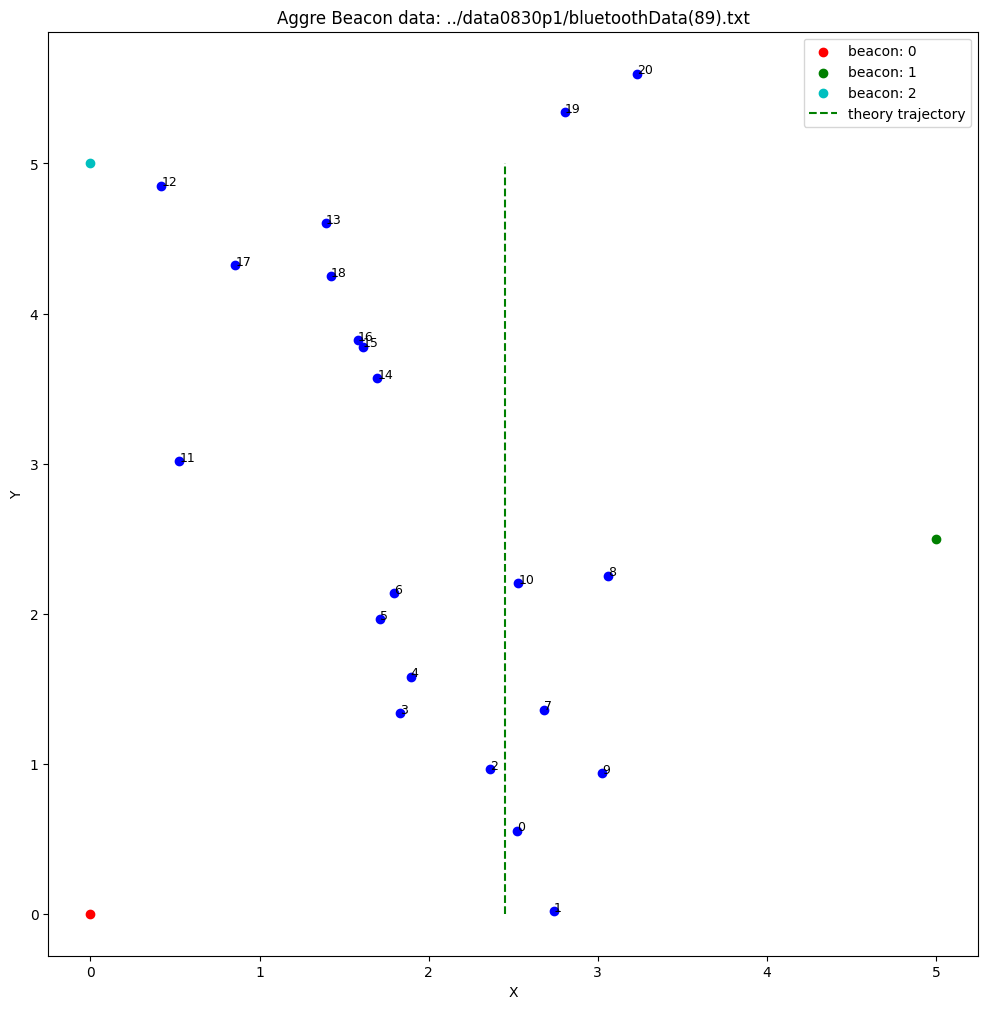

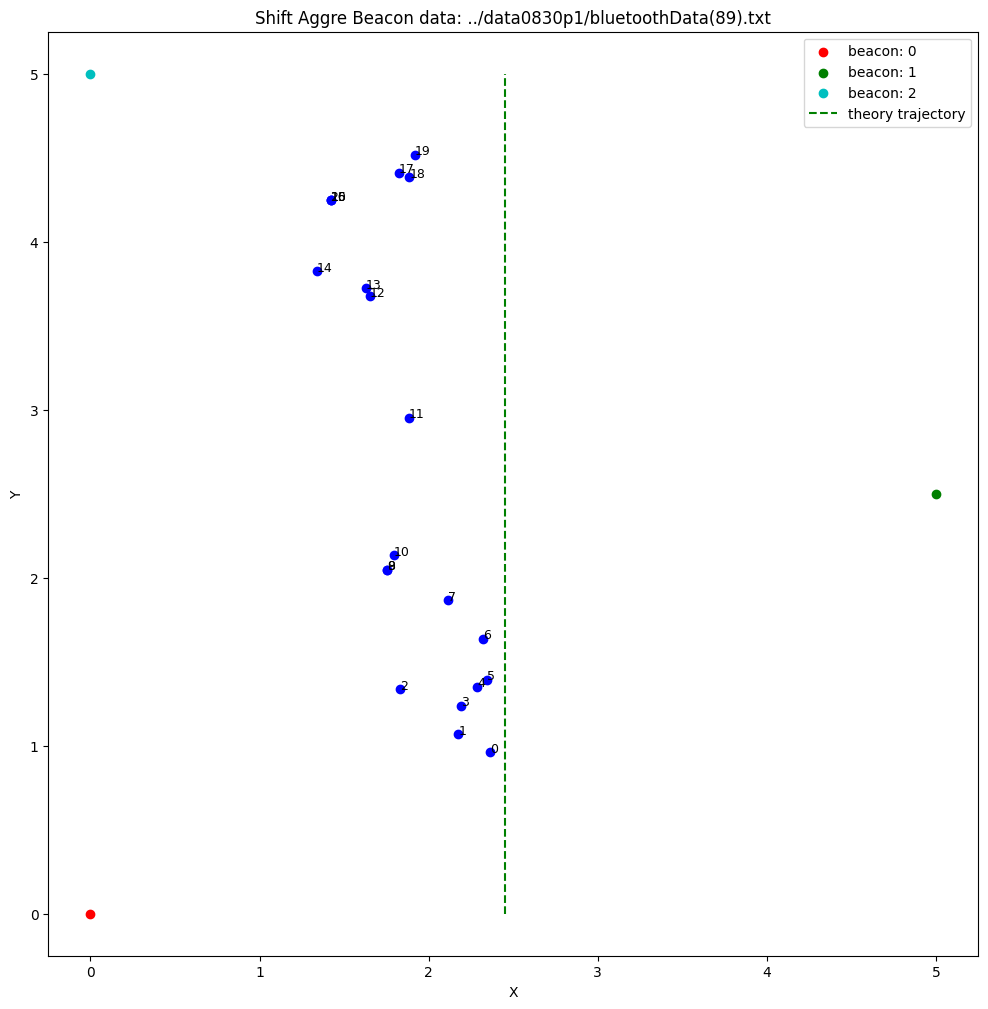

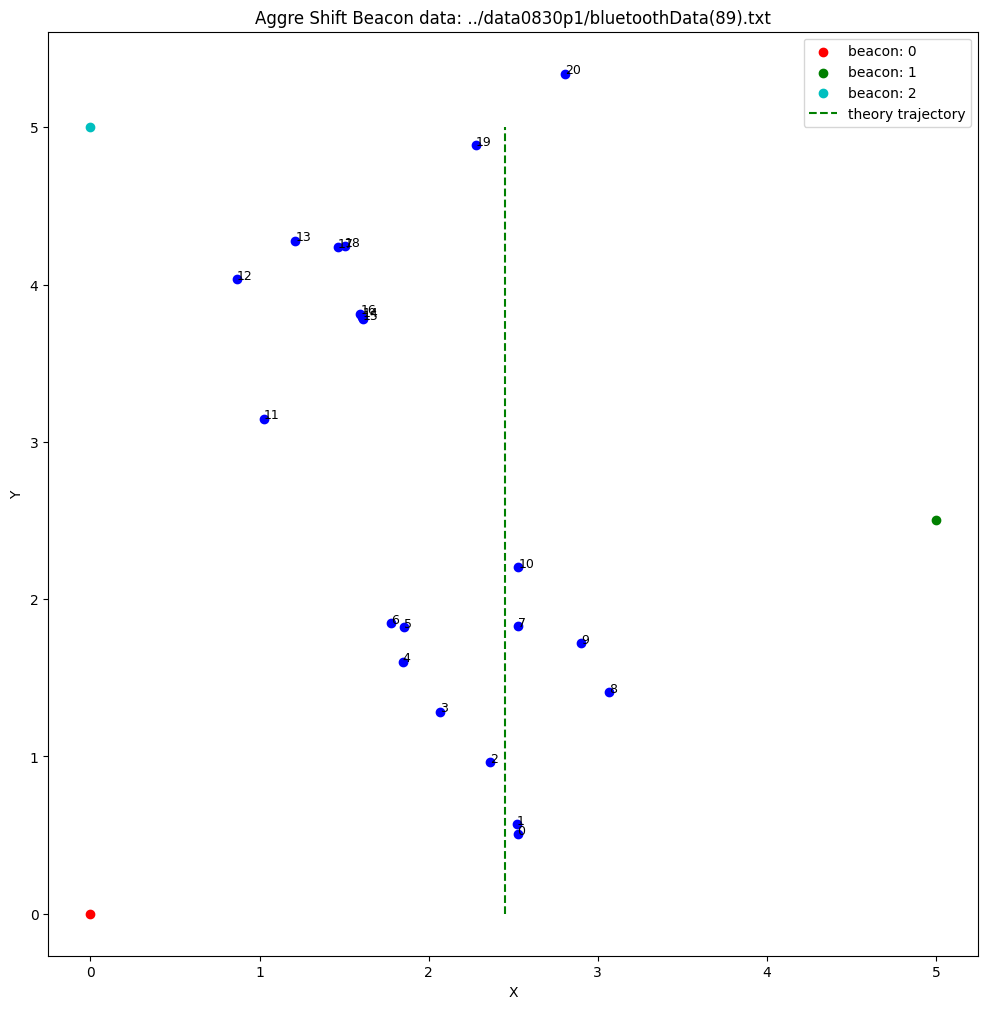

In [ ]:

    
for i, positions in enumerate(positionss):
    print("len positions", len(positions))
    args.beacon_data_file = args.beacon_data_dir + beacon_data_file
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    
    colors = ['r', 'g', 'c', 'm', 'y', 'k', 'b']
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
        
    print("positions", positions)
    for i, pos in enumerate(positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
        
    plt.vlines(2.45, 0, 5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Beacon data: {args.beacon_data_file}")
    plt.show()

    print("positions", positions)
    
    repre_size = 8
    aggre_size = 3
    
    repre_positions = aggregate_continuous_points_sliding(positions, repre_size)
    aggre_positinons = aggregate_continuous_points(positions, aggre_size)
    repre_aggre_positions = aggregate_continuous_points_sliding(aggre_positinons, repre_size)
    aggre_repre_positions = aggregate_continuous_points(repre_positions, aggre_size)
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    
    plt.vlines(2.45, 0, 5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Repre Beacon data: {args.beacon_data_file}")
    plt.show()


    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(aggre_positinons):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    
    plt.vlines(2.45, 0, 5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Aggre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_aggre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    plt.vlines(2.45, 0, 5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Repre Aggre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(aggre_repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    plt.vlines(2.45, 0, 5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Aggre Repre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    repres_aggre_positions = []
    repre_num = 4
    for i in range(repre_num):
        repres_aggre_positions.append(aggregate_continuous_points_sliding(aggre_repre_positions, repre_num, repre_size))
    
    plt.figure(figsize=(24, 24))
    for idx, repres_aggre_pos in enumerate(repres_aggre_positions):
        plt.subplot(2, 2, idx + 1)
        for i, k in enumerate(actual_coords.keys()):
            plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
        for i, pos in enumerate(repres_aggre_pos):
            if pos is None:
                continue
            plt.scatter(pos[0], pos[1], c='b')
            plt.text(pos[0], pos[1], f"{i}", fontsize=9)
        plt.vlines(2.45, 0, 5, colors='g', linestyles='dashed', label='theory trajectory')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f"Repres Aggre Beacon data {idx + 1}")
    plt.tight_layout()
    plt.show()
    


In [ ]:
def calculate_mae(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.mean(np.abs(actual_coords - estimated_coords))

def calculate_rmse(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.sqrt(np.mean((actual_coords - estimated_coords) ** 2))

def calculate_rmse1(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    distances = np.linalg.norm(actual_coords - estimated_coords, axis=1)
    return np.sqrt(np.mean((distances) ** 2))

def calculate_average_distance(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.mean(np.sqrt(np.sum((actual_coords - estimated_coords) ** 2, axis=1)))

v = 1.0
for i, positions in enumerate(positionss):
    actual_coords = [[2.4, 0.1*j, 0.9] for j in range(len(positions))]
    repre_positions = aggregate_continuous_points_sliding(positions, 8)
    aggre_positinons = aggregate_continuous_points(positions, 3)
    
    repre_positions = np.array(repre_positions)
    actual_coords = np.array(actual_coords)
    actual_coords = actual_coords[:,:, np.newaxis]
    
    print("shapes", np.array(actual_coords).shape, np.array(positions).shape, np.array(repre_positions).shape, np.array(aggre_positinons).shape)
    
    print("actual_coords", actual_coords[-10:])
    print("MAE for file: ", files[i])
    print("MAE for actual_coords: ", calculate_mae(actual_coords, positions))
    print("MAE for repre_positions: ", calculate_mae(actual_coords, repre_positions))
    print("RMSE for actual_coords: ", calculate_rmse(actual_coords, positions))
    print("RMSE for repre_positions: ", calculate_rmse(actual_coords, repre_positions))
    print("RMSE1 for actual_coords: ", calculate_rmse1(actual_coords, positions))
    print("RMSE1 for repre_positions: ", calculate_rmse1(actual_coords, repre_positions))
    print("Average distance for actual_coords: ", calculate_average_distance(actual_coords, positions))
    print("Average distance for repre_positions: ", calculate_average_distance(actual_coords, repre_positions))



# plt.figure(figsize=(12, 12))
# plt.plot(actual_coords[:, 0], actual_coords[:, 1], 'bo-', label='Actual Trajectory')
# plt.plot(estimated_coords[:, 0], estimated_coords[:, 1], 'ro-', label='Estimated Trajectory')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Actual vs Estimated Trajectory')
# plt.show()

shapes (62, 3, 1) (62, 3, 1) (62, 3, 1) (21, 3, 1)
actual_coords [[[2.4]
  [5.2]
  [0.9]]

 [[2.4]
  [5.3]
  [0.9]]

 [[2.4]
  [5.4]
  [0.9]]

 [[2.4]
  [5.5]
  [0.9]]

 [[2.4]
  [5.6]
  [0.9]]

 [[2.4]
  [5.7]
  [0.9]]

 [[2.4]
  [5.8]
  [0.9]]

 [[2.4]
  [5.9]
  [0.9]]

 [[2.4]
  [6. ]
  [0.9]]

 [[2.4]
  [6.1]
  [0.9]]]
MAE for file:  bluetoothData(88).txt
MAE for actual_coords:  0.5507543223358164
MAE for repre_positions:  0.543266536742984
RMSE for actual_coords:  0.8668945150786492
RMSE for repre_positions:  0.8555926994167594
RMSE1 for actual_coords:  1.5015053449190048
RMSE1 for repre_positions:  1.4819300259748338
Average distance for actual_coords:  1.3332685881181232
Average distance for repre_positions:  1.3037230618487592
shapes (65, 3, 1) (65, 3, 1) (65, 3, 1) (22, 3, 1)
actual_coords [[[2.4]
  [5.5]
  [0.9]]

 [[2.4]
  [5.6]
  [0.9]]

 [[2.4]
  [5.7]
  [0.9]]

 [[2.4]
  [5.8]
  [0.9]]

 [[2.4]
  [5.9]
  [0.9]]

 [[2.4]
  [6. ]
  [0.9]]

 [[2.4]
  [6.1]
  [0.9]]

 [[2.4]


In [ ]:
# # visualize the beacon RSSI to distance
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict
# import pdb


# def rssi_to_distance(rssi):
#     txPower = -55.47
#     n = 3.106
#     return 10 ** ((txPower - rssi) / (10 * n))

# beacon_id_to_rssi = defaultdict(list)
# time_stamp = []
# print(beacon_data)
# for beacon_group in beacon_data:
#     if len(beacon_group) < 3:
#         print("beacon group length is less than 3")
#         continue
#     for beacon in beacon_group:
#         beacon_id = beacon['uuid']
#         beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
#     time_stamp.append(beacon['time'])

    
# for beacon_id, rssi_values in beacon_id_to_rssi.items():
#     if len(beacon_group[0]) <= 3:
#         print("beacon group length is less than 3")
#         continue
#     plt.figure(figsize=(12, 12))
#     distance = [rssi_to_distance(rssi) for rssi in rssi_values]
#     plt.plot(time_stamp, rssi_values, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('rssi')
#     plt.legend()
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.show()
    
#     plt.figure(figsize=(12, 12))
#     plt.plot(time_stamp, distance, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('distance(m)')
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.legend()
#     plt.show()
